In [1]:
import numpy as np
# for 문 얼마나 남았나 이쁘게 보기위해
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from datetime import datetime
import os

In [2]:
# 현재 나의 장치에서 gpu를 확인한다
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10962226482397392005
 xla_global_id: -1]

In [3]:
# gpu를 지정하여 진행을 할 수 있는데 현재 컴퓨터는 한대의 gpu밖에 없어 의미는 없으나 여러 gpu가 있는 pc의 경우 gpu를 지정할 수 있다
# tpu_name = 'grpc://'+os.environ['COLAB_TPU_ADDR']

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_name)

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# mirrrored_strategy = tf.distribute.TPUStrategy(resolver)

# mirrrored_strategy = tf.distribute.MirroredStrategy(['GPU:0'])

In [16]:
mirrrored_strategy = tf.distribute.MirroredStrategy(['GPU:0'])

In [17]:
# 지정된 gpu를 사용하여 프로세스를 진행한다.
with mirrrored_strategy.scope():
    # 데이터 셋 정의 - 텐서플로에서 제공하는 기본 데이터셋을 사용하여 진행해 보겠다.
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    # rgg 값을 0~1 사이로 normalize 해준다.
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # train/val splits - 검증을 위한 10%의 데이터를 따로 빼둔다.
    train_size = int(len(x_train) * 0.9)
    val_size = len(x_train) - train_size
    
    # 사실 텐서플로우에서 데이터 로드를 만들 필요는 없어 아래의 과정을 생략하고 input값의 reshape만 진행해도 된다.
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1024)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(buffer_size=1024)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    print(len(train_dataset),len(val_dataset),len(dataset),len(test_dataset))
     
    # 배치사이즈
    train_batch_size = 100
    val_batch_size = 10
    test_batch_size = 100

    # 데이터로더 정의
    train_dataloader = train_dataset.batch(train_batch_size, drop_remainder=True)
    val_dataloader = val_dataset.batch(val_batch_size, drop_remainder=True)
    test_dataloader = test_dataset.batch(test_batch_size, drop_remainder=True)
    
# sample_example = next(iter(train_dataloader))
# print(sample_example)

4422102/4422102 [==============================] - 0s 0us/step
54000 6000 60000 10000


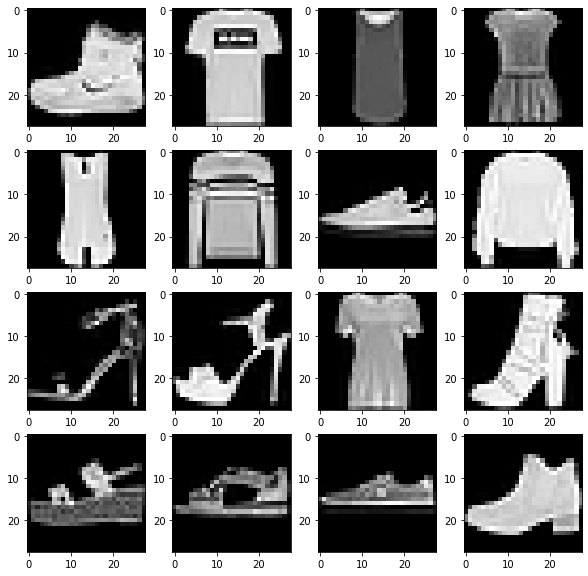

In [18]:
plt.figure(figsize=(10,10))
for c in range(16):
    plt.subplot(4,4,c+1)
    plt.imshow(x_train[c].reshape(28,28),cmap='gray')
plt.show()

In [19]:


# MLP 모델제작
class MLP(tf.keras.Model):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, out_dim: int):
        # tf.keras.Model 과 사용할 속성 정의
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.linear1 = tf.keras.layers.Dense(input_dim = input_dim, units = h1_dim)
        self.linear2 = tf.keras.layers.Dense(units= h2_dim)
        self.linear3 = tf.keras.layers.Dense(units= out_dim)        
        self.relu = tf.nn.relu
        
    # training 학습일때는 dropout을 키고 test에서는 끄도록 조정, 사실 model.fit()에서는 자동으로 true를 사용해서 설정할 필요없다.
    def call(self, input, training = False):
        x = self.flatten(input)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        out = tf.nn.softmax(out)
        return out
    
    # 아래의 과정들은 공부를 위한 오버라이딩이며 굳이 적지 않아도 된다.
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            outputs = self(images, training=True)
            preds = tf.argmax(outputs, 1)
            
            loss = self.compiled_loss(labels, outputs)
            
        # gradients 계산
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
        # update metrics
        self.compiled_metrics.update_state(labels, preds)
        
        logs = {m.name: m.result() for m in self.metrics}
        logs.update({'loss' : loss})
        # return a dict mapping metrics name to current values
        return logs
        
    def test_step(self, data):
        images, labels = data
        outputs = self(images, training=False)
        preds = tf.argmax(outputs, 1)
        loss = self.compiled_loss(labels, outputs)
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics name to current values
        logs = {m.name: m.result() for m in self.metrics}
        logs.update({'test_loss' : loss})
        return logs

In [20]:

class MLPwithDropout(tf.keras.Model):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, out_dim: int, dropout_prob: int):
        # tf.keras.Model 과 사용할 속성 정의
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.linear1 = tf.keras.layers.Dense(input_dim = input_dim, units = h1_dim)
        self.linear2 = tf.keras.layers.Dense(units= h2_dim)
        self.linear3 = tf.keras.layers.Dense(units= out_dim)    
        self.dropout = tf.keras.layers.Dropout(dropout_prob)    
        self.relu = tf.nn.relu
        
    # training 학습일때는 dropout을 키고 test에서는 끄도록 조정, 사실 model.fit()에서는 자동으로 true를 사용해서 설정할 필요없다.
    def call(self, input, training = False):
        x = self.flatten(input)
        x = self.relu(self.linear1(x))
        x = self.dropout(x, training= True)
        x = self.relu(self.linear2(x))
        x = self.dropout(x, training= True)
        out = self.linear3(x)
        out = tf.nn.softmax(out)
        return out
      # 아래의 과정들은 공부를 위한 오버라이딩이며 굳이 적지 않아도 된다.
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            outputs = self(images, training=True)
            preds = tf.argmax(outputs, 1)
            
            loss = self.compiled_loss(labels, outputs)
            
        # gradients 계산
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
        # update metrics
        self.compiled_metrics.update_state(labels, preds)
        
        logs = {m.name: m.result() for m in self.metrics}
        logs.update({'loss' : loss})
        # return a dict mapping metrics name to current values
        return logs
        
    def test_step(self, data):
        images, labels = data
        outputs = self(images, training=False)
        preds = tf.argmax(outputs, 1)
        loss = self.compiled_loss(labels, outputs)
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics name to current values
        logs = {m.name: m.result() for m in self.metrics}
        return logs

In [21]:
# model define
n_class = 10
max_epoch = 50
# 모델설계
with mirrrored_strategy.scope():

    model = MLPwithDropout(28*28*1, 128, 64, n_class, dropout_prob = 0.3)
    model_name = type(model).__name__
    
    loss_function = tf.losses.SparseCategoricalCrossentropy()
    
    lr = 1e-3
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    
    model.compile(
        loss= loss_function,
        optimizer = optimizer,
        metrics = [tf.keras.metrics.Accuracy()]
    )


    model.build((1, 28*28*1))
model.summary()

# model.fit(train_dataloader,test_dataloader,ca)

Model: "ml_pwith_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  100480    
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  650       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [22]:
datetime.now().strftime('%Y-%m-%d-%H:%M:%S')

'2023-02-07-13:47:45'

In [23]:
# define logging & callbacks
log_interval = 100

run_name =  f"{datetime.now().strftime('%Y-%m-%d-%H%M%S')}-{model_name}"
run_dirname = 'dnn-tutorial-mnist'
log_dir = os.path.join('/content/sample_data',run_dirname,run_name)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir, update_freq= log_interval)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=True)

In [24]:
log_dir

'/content/sample_data/dnn-tutorial-mnist/2023-02-07-134746-MLPwithDropout'

In [25]:
# 텐서보드를 활용해 모델링 내용을 확인해 본다. 
# %load_ext tensorboard
# %tensorboard --logdir  /content/sample_data
# 
model.fit(
    train_dataloader, 
    validation_data=val_dataloader, 
    epochs=max_epoch ,
    callbacks=[tb_callback, early_stop_callback]
)

Epoch 1/50
540/540 [==============================] - 10s 9ms/step - loss: 0.5700 - accuracy: 0.7477 - val_loss: 0.5081 - val_accuracy: 0.8192
Epoch 2/50
540/540 [==============================] - 3s 6ms/step - loss: 0.5953 - accuracy: 0.8293 - val_loss: 0.4684 - val_accuracy: 0.8410
Epoch 3/50
540/540 [==============================] - 5s 9ms/step - loss: 0.4712 - accuracy: 0.8434 - val_loss: 0.4381 - val_accuracy: 0.8432
Epoch 4/50
540/540 [==============================] - 3s 6ms/step - loss: 0.4274 - accuracy: 0.8538 - val_loss: 0.4282 - val_accuracy: 0.8545
Epoch 5/50
540/540 [==============================] - 3s 6ms/step - loss: 0.6160 - accuracy: 0.8598 - val_loss: 0.4061 - val_accuracy: 0.8558
Epoch 6/50
540/540 [==============================] - 3s 6ms/step - loss: 0.3927 - accuracy: 0.8641 - val_loss: 0.4017 - val_accuracy: 0.8588
Epoch 7/50
540/540 [==============================] - 3s 6ms/step - loss: 0.3380 - accuracy: 0.8683 - val_loss: 0.3992 - val_accuracy: 0.8635
Epoch

In [26]:
model.evaluate(test_dataloader)

100/100 [==============================] - 2s 3ms/step - loss: 0.4088 - accuracy: 0.8643


[0.40883147716522217, 0.864300012588501]

In [27]:
# 모델의 피팅과정을 보는 과정을 공부하기 위함이지 라이브러리에서 처리해주는 구간이므로 일일히 리스트로 만들어 결과를 볼 필요는 없다.
test_labels_list = []
test_preds_list = []
test_outputs_list = []

for i ,(test_images,test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc='testing')):
    with mirrrored_strategy.scope():
        test_outputs = model(test_images)
    test_pred = tf.argmax(test_outputs, 1)
    
    final_outs = test_outputs.numpy()
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_pred.numpy())
    test_labels_list.extend(test_labels.numpy())
    
test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

test_accuracy = np.mean(test_preds_list == test_labels_list)
print(f'/nacc : {test_accuracy}%')

testing: 100%|██████████| 100/100 [00:00<00:00, 164.02it/s]

/nacc : 0.8653%


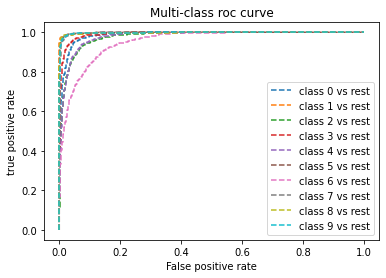

auc_score :  0.9875506722222221


In [28]:
# ROC Curce
from sklearn.metrics import roc_curve,roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i],pos_label=i)
    
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label = f"class {i} vs rest")
plt.title('Multi-class roc curve')
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')
plt.show()

auc_score = roc_auc_score(test_labels_list, test_outputs_list, multi_class='ovo', average='macro')
print('auc_score : ',auc_score)